## Exploratory Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("whitegrid")

### Reading in datasets

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

### Basic cleaning of dataset, creation of new features

Explanation of cleaning logic
- Some `flat_type` coded as `x-room`, while others coded as `x room`. To remove hyphen. 
- `storey` provided as `lower-limit to upper-limit`. It doesn't really make sense to use this as a categorical variable since there's some order to it. Hence we take the mean of the lower-limit and upper-limit.
- `lease duration` is a new column to show how old the flat has been leased from the government at the point of sales. Presumably, the older the flat, the lower the price it will be.

In [140]:
train['price_per_area'] = train['resale_price']/train['floor_area_sqm']
train['flat_type'] = train['flat_type'].str.replace('-', ' ')
train['year'] = train.month.str[:4].astype('int')
test['year'] = train.month.str[:4].astype('int')
train['lease_duration'] = train['year']-train['lease_commence_date']
train['storey'] = (train.storey_range.str[-2:].astype('int') + train.storey_range.str[:2].astype('int'))/2

### Coverage of dataset

Dataset comprises >500K resale flat transactions in Singapore over 20 years from 2000 to 2020. 
- Volume of transactions significantly goes down after 2009. 

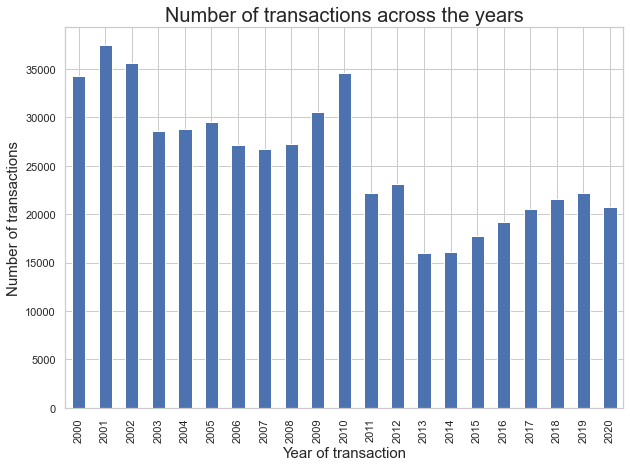

In [86]:
(train.year.value_counts() + test.year.value_counts()).sort_index().plot(kind='bar')
plt.title('Number of transactions across the years', fontsize=20)
plt.xlabel('Year of transaction', fontsize=15)
plt.ylabel('Number of transactions', fontsize=15)
plt.show()

There appears to be some resale transactions inaccurately coded as happening in the `north region`, when in reality, they appear to be embedded in the `west region`. Upon further investigation, we found that they all belong in the town of `kallang/whampoa`.
- We did not drop these data points because in the test set, they are also coded consistently as being in the `north region`.
- Neither did we modify the region because we believe other variables like `town` can already capture the location characteristics, if any.

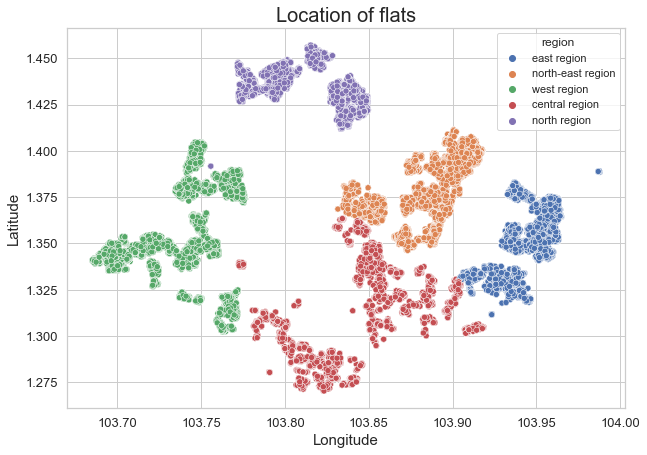

In [97]:
p = sns.scatterplot(x=long, y=lat, hue=region)
p.axes.set_title("Location of flats",fontsize=20)
p.set_ylabel("Latitude",fontsize=15)
p.set_xlabel("Longitude",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

In [100]:
train[((train['longitude']<= 103.76) & (train['region']=="north region"))].head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price,price_per_area,year,storey
373,2001-04,kallang/whampoa,3 room,3,Jalan Batu,01 to 03,60.0,standard,uncategorized,1969,1.391731,103.755741,0.0,gali batu,sungei kadut,north region,108000.0,1800.0,2001,2.0
11638,2004-03,kallang/whampoa,3 room,3,jalan batu,01 to 03,60.0,standard,uncategorized,1969,1.391731,103.755741,0.0,gali batu,sungei kadut,north region,153000.0,2550.0,2004,2.0
23580,2002-07,kallang/whampoa,3 room,3,jalan batu,04 to 06,60.0,standard,uncategorized,1969,1.391731,103.755741,0.0,gali batu,sungei kadut,north region,118800.0,1980.0,2002,5.0
40889,2002-08,kallang/whampoa,3 room,3,jalan batu,04 to 06,60.0,standard,uncategorized,1969,1.391731,103.755741,0.0,gali batu,sungei kadut,north region,135000.0,2250.0,2002,5.0
44198,2020-03,kallang/whampoa,3 room,3,Jalan Batu,10 to 12,60.0,standard,uncategorized,1969,1.391731,103.755741,0.0,gali batu,sungei kadut,north region,225000.0,3750.0,2020,11.0


### Main Insights

**Insight 1: Floor area is a super important variable.**
- Floor area and resale price are clearly positive correlated.
- Higher floor areas naturally corresponds to bigger flat types. However there are some outliers dataset - some 3-room flats are too huge! We decided to not remove the 3-room flats with such a huge floor area even though it's somewhat weird, because the test set consists of flats like this too.
- Implication is that we need to include floor area as a predictor.

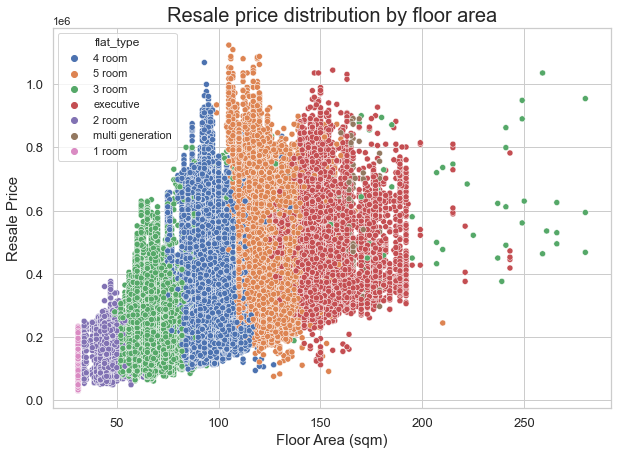

In [102]:
p = sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=train)
p.axes.set_title("Resale price distribution by floor area",fontsize=20)
p.set_ylabel("Resale Price",fontsize=15)
p.set_xlabel("Floor Area (sqm)",fontsize=15)
p.tick_params(labelsize=13)

plt.show()

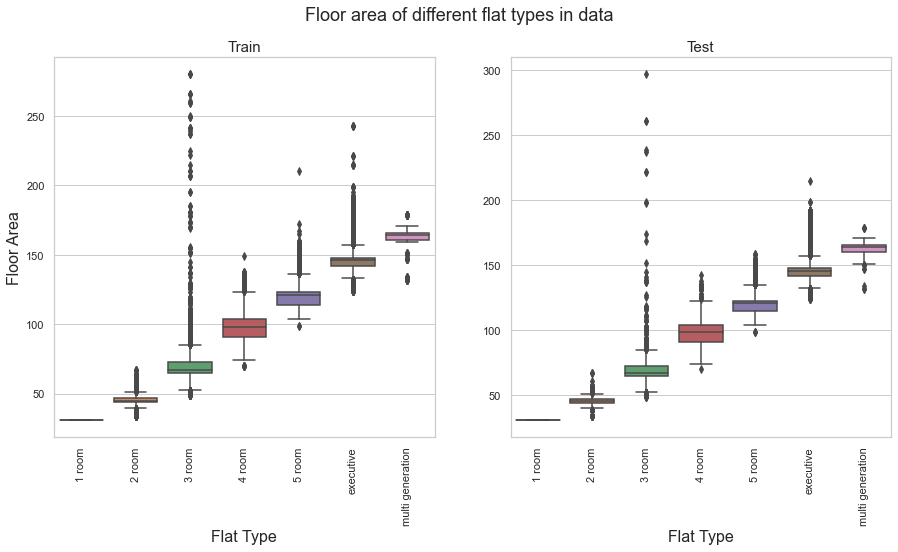

In [139]:
order_flat = train.groupby('flat_type')['floor_area_sqm'].median().index

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Floor area of different flat types in data', fontsize=18)

# Trainset
sns.boxplot(ax=axes[0], x=train['flat_type'], y=train['floor_area_sqm'], order=order_flat)
axes[0].set_title('Train', fontsize=15)

# Test set
sns.boxplot(ax=axes[1], x=test['flat_type'], y=test['floor_area_sqm'], order=order_flat)
axes[1].set_title('Test', fontsize=15)

axes[0].tick_params(labelrotation=90, axis='x')
axes[1].tick_params(labelrotation=90, axis='x')
axes[0].set_ylabel('Floor Area', fontsize=16)
axes[1].set_ylabel('')
axes[0].set_xlabel('Flat Type', fontsize=16)
axes[1].set_xlabel('Flat Type', fontsize=16)

plt.show()

**Insight 2: After accounting for floor area, some variables such as flat type and flat model seem less important in price prediction.**
- At first thought, it seems like `flat model` is a potentially important predictor of resale prices. However, after accouting for floor area, the variation narrows, and only certain flat types stand out, like `type s1` and `type s2` flats. 
- DEspite so, we made the decision to keep this variable as a predictor, because if the variable is truly not important, the model will learn to drown out its effect.


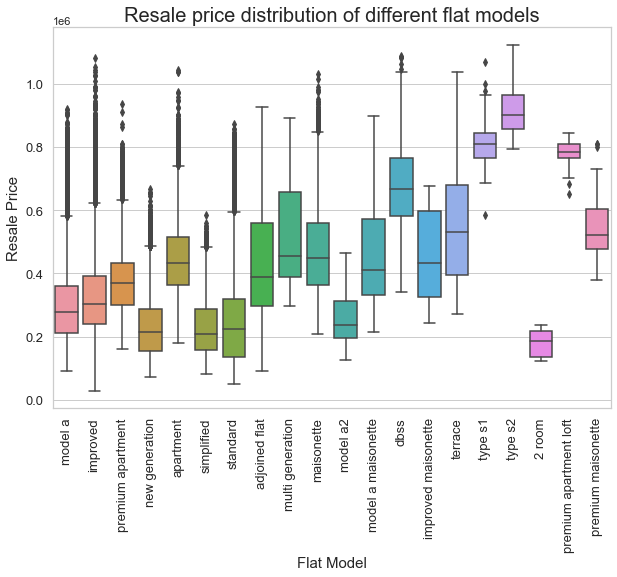

In [8]:
p = sns.boxplot(x='flat_model',y='resale_price', data=train)
plt.xticks(rotation=90)
p.axes.set_title("Resale price distribution of different flat models",fontsize=20)
p.set_xlabel("Flat Model",fontsize=15)
p.set_ylabel("Resale Price",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

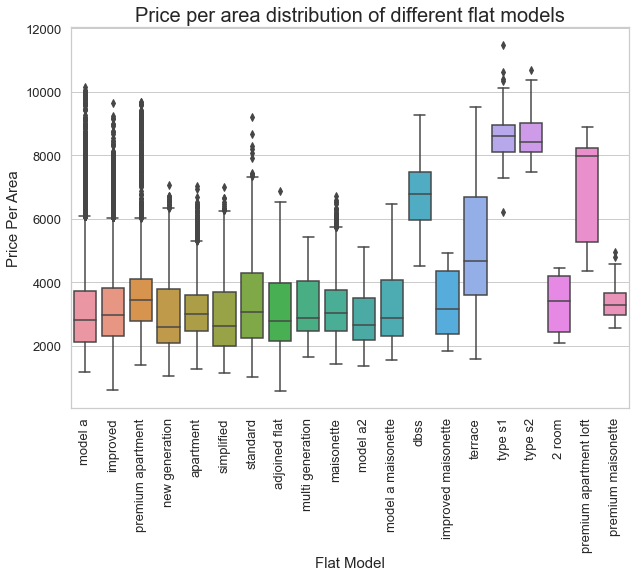

In [11]:
p = sns.boxplot(x='flat_model',y='price_per_area', data=train)
plt.xticks(rotation=90)
p.axes.set_title("Price per area distribution of different flat models",fontsize=20)
p.set_xlabel("Flat Model",fontsize=15)
p.set_ylabel("Price Per Area",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

Similarly, as above, there doesn't appear to be much diffference in price per area for different flat types. However, we do observe that there is some difference in price variation, with `1 room` flats displaying the highest variance in price per area.

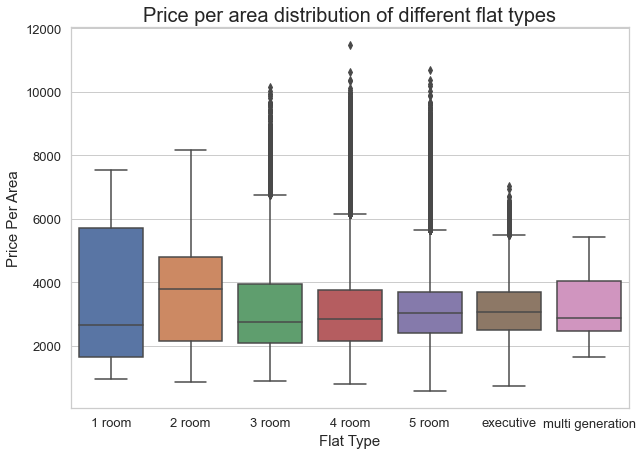

In [21]:
order_flat = train.groupby('flat_type')['floor_area_sqm'].median().index
p = sns.boxplot(x='flat_type',y='price_per_area', data=train, order=order_flat)
p.axes.set_title("Price per area distribution of different flat types",fontsize=20)
p.set_xlabel("Flat Type",fontsize=15)
p.set_ylabel("Price Per Area",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

**Insight 2: Location of resale flat matters.**
- In particular, we observe that flats from the west region tend to be the cheapest, while flats from central region are likely more expensive.
- If we look at it at a town level, there also appears to be much variation in flat prices. Flats from Woodlands are the cheapest, while flats in central area or punggol are expensive.
- The implication of this is that we should include both `town` and `region` as features. 

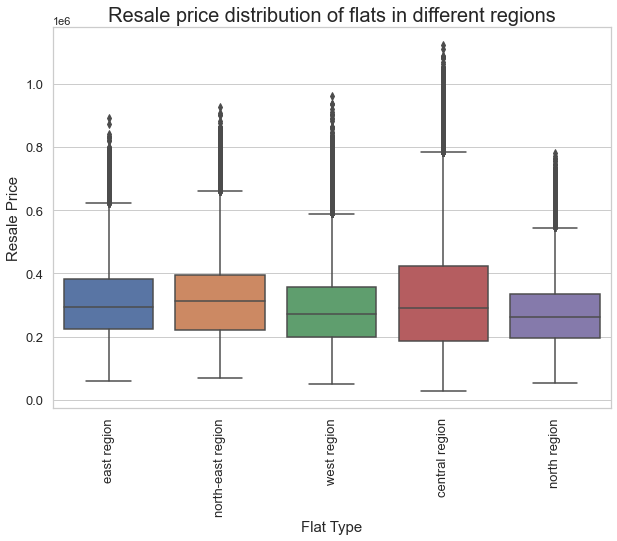

In [22]:
p = sns.boxplot(x='region',y='resale_price', data=train)
plt.xticks(rotation=90)
p.axes.set_title("Resale price distribution of flats in different regions",fontsize=20)
p.set_xlabel("Flat Type",fontsize=15)
p.set_ylabel("Resale Price",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

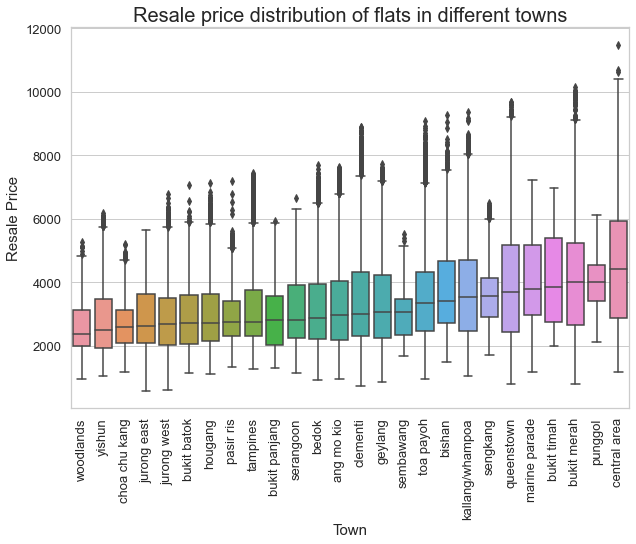

In [24]:
order = train.groupby('town').price_per_area.agg('median').sort_values().index
p = sns.boxplot(x='town',y='price_per_area', data=train, order=order)
plt.xticks(rotation=90)
p.axes.set_title("Resale price distribution of flats in different towns",fontsize=20)
p.set_xlabel("Town",fontsize=15)
p.set_ylabel("Resale Price",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

**Insight 3: Prices of houses seem quite stable across the years, except from between 2007 and 2012**
- Implication is to include `Year` as a categorical/interval variable to account for unobserved latent variables - e.g. economic situation, government cooling measures.
- Trend is the same, regardless of whether it's price per area or price.

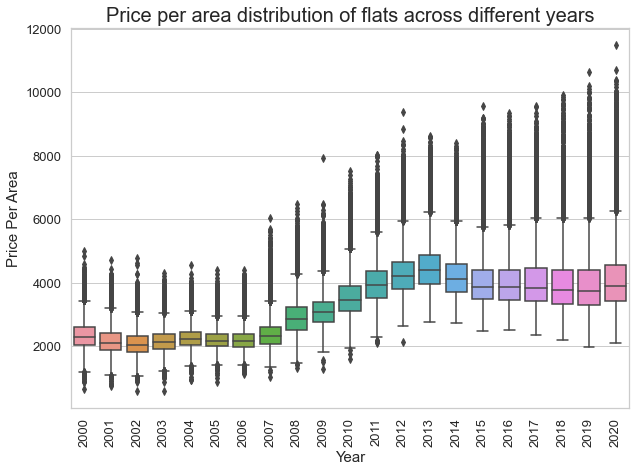

In [64]:
p = sns.boxplot(x=train['year'],y=train['price_per_area'])
plt.xticks(rotation=90)
p.axes.set_title("Price per area distribution of flats across different years",fontsize=20)
p.set_xlabel("Year",fontsize=15)
p.set_ylabel("Price Per Area",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

**Insight 4: Some variables can be dropped**
- `elevation` and  `eco-category` has no variation in values.
- `subzone`, `street_name` and `block`has way too many categories. It is not meaningful to use these two variables as the number of flats that belong to each `subzone`, `street_name` or `block` are too small. Furthermore, if we want to capture location effect, `town` and `region` would have adequately captured it.
- `town` and `planning_area` are quite similar, except that `planning_area` is slightly more fine-grained for certain areas - e.g. `central_area`, `kallang/whampoa`. `planning_area` to be dropped as some categories are way too small - e.g. `queenstown` only has 72 observations in training set. 

In [53]:
train.elevation.value_counts(), test.elevation.value_counts()

(0.0    431732
 Name: elevation, dtype: int64,
 0.0    107934
 Name: elevation, dtype: int64)

In [52]:
train.eco_category.value_counts(), test.eco_category.value_counts()

(uncategorized    431732
 Name: eco_category, dtype: int64,
 uncategorized    107934
 Name: eco_category, dtype: int64)

In [55]:
train.street_name.nunique()

1103

In [48]:
train.block.nunique()

2472

In [62]:
train.subzone.nunique()

155

In [61]:
train.groupby(['town', 'planning_area']).size()

town             planning_area
ang mo kio       ang mo kio       22273
bedok            bedok            27606
bishan           bishan            9121
bukit batok      bukit batok      19289
bukit merah      bukit merah      15858
bukit panjang    bukit panjang    15006
bukit timah      bukit timah       1011
                 tanglin             79
central area     downtown core       80
                 outram            1555
                 rochor            1424
choa chu kang    choa chu kang    19985
clementi         clementi         11260
geylang          geylang          12085
hougang          hougang          23838
jurong east      jurong east      10977
jurong west      jurong west      32875
kallang/whampoa  downtown core      154
                 kallang           7603
                 novena            3264
                 queenstown          72
                 sungei kadut        38
marine parade    marine parade     3248
pasir ris        changi             122
         

**Insight 5: Resale prices really do increase the higher the flat goes**

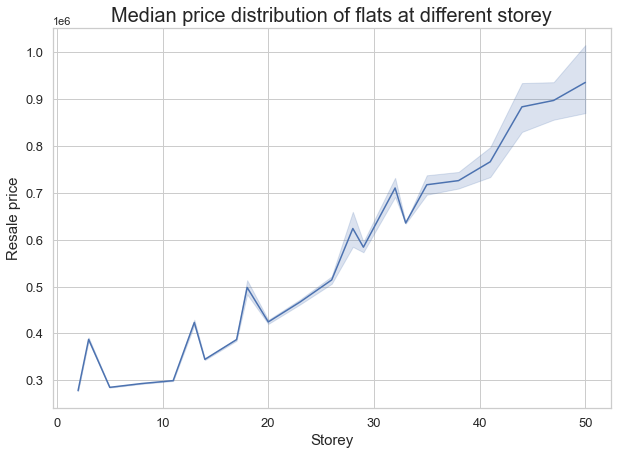

In [76]:
p = sns.lineplot(x=train['storey'],y=train['resale_price'])
p.axes.set_title("Median price distribution of flats at different storey",fontsize=20)
p.set_xlabel("Storey",fontsize=15)
p.set_ylabel("Resale price",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

**Insight 6: Lease duration does not have a negative correlation with price per area**
- We used `price_per_area` instead of `resale_price` because older flats tend to be larger in size.
- Surprisingly, `price_per_area` is positive correlated with `lease_duration`. This does not necessarily indicate the presence of any relationship. In fact, other latent variables might be at play - e.g. older flats might be in better locations.
- Regression analysis in later parts of the project will yield more insights.

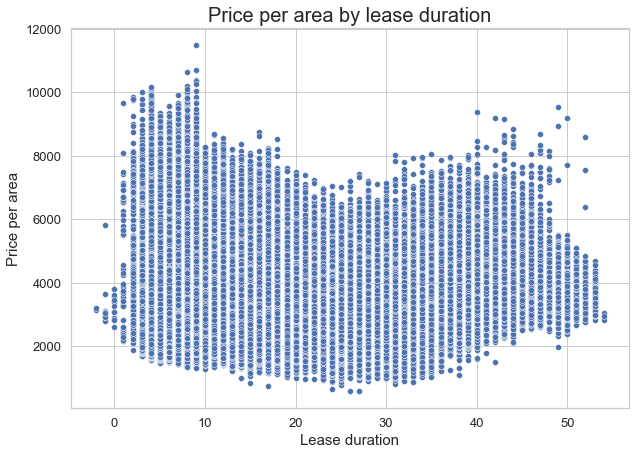

In [149]:
p = sns.scatterplot(x='lease_duration', y='price_per_area', data=train)
p.axes.set_title("Price per area by lease duration",fontsize=20)
p.set_ylabel("Price per area",fontsize=15)
p.set_xlabel("Lease duration",fontsize=15)
p.tick_params(labelsize=13)
plt.show()

In [143]:
train[['lease_duration', 'price_per_area']].corr(method='pearson')

,lease_duration,price_per_area
lease_duration,1.000000,0.212324
price_per_area,0.212324,1.000000
